# Task 1: Advanced Exploratory Data Analysis (EDA) & Feature Engineering Before building the model, you must deeply understand and enrich the dataset. 

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Masum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas 

In [4]:
df = pandas.read_csv("kc_house_data.csv")

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
# Function to randomly set about 5% values to NaN
def add_missing_values(series, frac=0.05, random_state=42):
    series = series.copy()
    np.random.seed(random_state)
    n_missing = int(len(series) * frac)
    missing_indices = np.random.choice(series.index, n_missing, replace=False)
    series.loc[missing_indices] = np.nan
    return series

In [7]:
# Add missing values to 'sqft_lot' and 'bathrooms'
df["sqft_lot"] = add_missing_values(df["sqft_lot"], frac=0.05)
df["bathrooms"] = add_missing_values(df["bathrooms"], frac=0.05)

In [8]:
# Check how many missing values we introduced
print(df[["sqft_lot", "bathrooms"]].isnull().sum())

sqft_lot     1080
bathrooms    1080
dtype: int64


# 1A. Outlier detection using boxplots and IQR rule

In [9]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Masum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


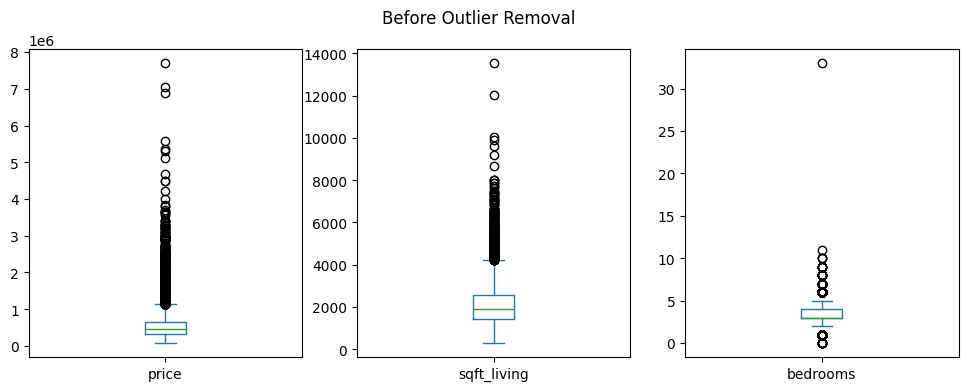

Rows after outlier removal: 19825


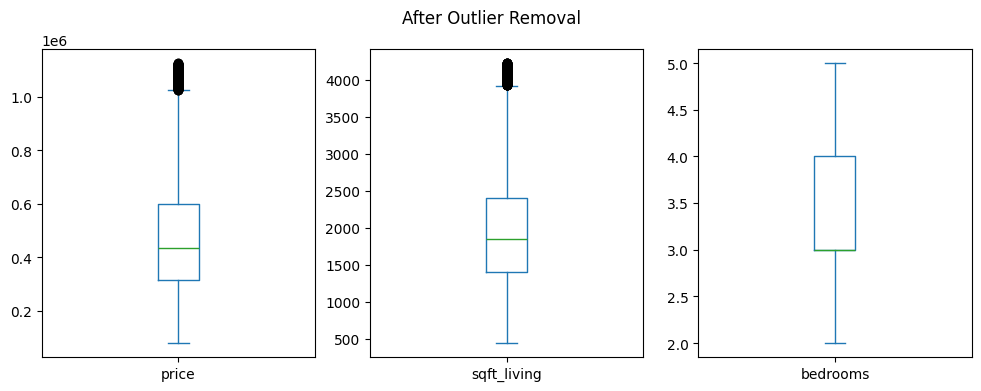

In [10]:
import matplotlib.pyplot as plt

cols = ["price","sqft_living","bedrooms"]
df[cols].plot(kind="box", subplots=True, layout=(1,3), figsize=(12,4), title="Before Outlier Removal")
plt.show()

def remove_outliers_iqr(df, cols, k=1.5):
    mask = pd.Series(True, index=df.index)
    for c in cols:
        q1, q3 = df[c].quantile([0.25,0.75])
        iqr = q3 - q1
        mask &= df[c].between(q1 - k*iqr, q3 + k*iqr)
    return df[mask]

df = remove_outliers_iqr(df, cols)
print("Rows after outlier removal:", len(df))
df[cols].plot(kind="box", subplots=True, layout=(1,3), figsize=(12,4), title="After Outlier Removal")
plt.show()

# 1B. Advanced Feature Engineering

In [11]:
df["date"] = pd.to_datetime(df["date"])
df["sale_year"] = df["date"].dt.year
df["sale_month"] = df["date"].dt.month
df["house_age"] = df["sale_year"] - df["yr_built"]

df["was_renovated"] = (df["yr_renovated"] != 0).astype(int)
df["age_since_renovation"] = np.where(
    df["yr_renovated"]==0,
    df["house_age"],
    df["sale_year"] - df["yr_renovated"]
)

def safe_div(a,b): return np.where((b==0)|(pd.isna(b)), np.nan, a/b)
df["sqft_living_per_floor"] = safe_div(df["sqft_living"], df["floors"])
df["bath_per_bed"] = safe_div(df["bathrooms"], df["bedrooms"])

df[["sale_year","sale_month","house_age","was_renovated","age_since_renovation","sqft_living_per_floor","bath_per_bed"]].head()

,sale_year,sale_month,house_age,was_renovated,age_since_renovation,sqft_living_per_floor,bath_per_bed
0,2014,10,59,0,59,1180.0,0.333333
1,2014,12,63,1,23,1285.0,0.750000
2,2015,2,82,0,82,770.0,0.500000
3,2014,12,49,0,49,1960.0,0.750000
4,2015,2,28,0,28,1680.0,0.666667


# Task 2: Build a Sophisticated Preprocessing Pipeline 

# 2A. Identify Feature Groups

Numerical: sqft_living, sqft_lot, bathrooms, bedrooms, house_age, sqft_living_per_floor, bath_per_bed

Categorical: zipcode

Passthrough: grade, condition, was_renovated

# 2B. Pipelines


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ["sqft_living","sqft_lot","bathrooms","bedrooms","house_age","sqft_living_per_floor","bath_per_bed"]
categorical_features = ["zipcode"]
passthrough = ["grade","condition","was_renovated"]

numeric_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features),
    ("passthrough", "passthrough", passthrough)
])

# Task 3: Model Training and Hyperparameter Tuning 

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["price"])
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Select Candidate Models and Hyperparameter Tuning with GridSearchCV

In [14]:
pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
    --------------------------------------- 0.8/56.8 MB 2.4 MB/s eta 0:00:24
   - -------------------------------------- 1.8/56.8 MB 3.1 MB/s eta 0:00:19
   -- ------------------------------------- 3.1/56.8 MB 3.8 MB/s eta 0:00:14
   -- ------------------------------------- 4.2/56.8 MB 4.3 MB/s eta 0:00:13
   --- ------------------------------------ 5.5/56.8 MB 4.6 MB/s eta 0:00:12
   ---- ----------------------------------- 6.8/56.8 MB 4.8 MB/s eta 0:00:11
   ----- ---------------------------------- 7.9/56.8 MB 4.9 MB/s eta 0:00:11
   ------ --------------------------------- 9.2/56.8 MB 5.0 MB/s eta 0:00:10
   ------- -------------------------------- 10.5/56.8 MB 5.1 MB/s eta 0:00:10
   -------- ------------------------------- 11.5/56.8 MB 5.2 MB/s eta 0:00:09
   --------- ------------------------------ 12.8/56.8 MB 5.2 MB/s eta 0:00:09
   -------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Masum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# 3A. Select Candidate Models

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Dictionary of models + parameters to test
grids = {
    "RF": (
        RandomForestRegressor(random_state=42),
        {
            "reg__n_estimators": [100, 200],
            "reg__max_depth": [None, 12]
        }
    ),
    "GB": (
        GradientBoostingRegressor(random_state=42),
        {
            "reg__n_estimators": [100, 200],
            "reg__learning_rate": [0.05, 0.1]
        }
    ),
    "XGB": (
        XGBRegressor(random_state=42, objective="reg:squarederror"),
        {
            "reg__n_estimators": [100, 200],
            "reg__learning_rate": [0.05, 0.1],
            "reg__max_depth": [3, 6]
        }
    )
}

# 3B. Hyperparameter Tuning with GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

searches = {}

for name, (mdl, params) in grids.items():
    pipe = Pipeline([
        ("prep", preprocessor),  
        ("reg", mdl)             
    ])
    
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    
    gs.fit(X_train, y_train)
    searches[name] = gs
    
    print(f"{name} → Best RMSE: {-gs.best_score_:.2f}")
    print("   Best Params:", gs.best_params_, "\n")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
RF → Best RMSE: 96605.25
   Best Params: {'reg__max_depth': None, 'reg__n_estimators': 200} 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
GB → Best RMSE: 93952.96
   Best Params: {'reg__learning_rate': 0.1, 'reg__n_estimators': 200} 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGB → Best RMSE: 87136.74
   Best Params: {'reg__learning_rate': 0.1, 'reg__max_depth': 6, 'reg__n_estimators': 200} 



# Task 4: Evaluation and Interpretation 

# 4A. Final Evaluation

In [20]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define RMSE manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Pick the best model
best_name, best_gs = min(searches.items(), key=lambda kv: -kv[1].best_score_)
best_model = best_gs.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Report metrics
print("Best Model:", best_name)
print(f"R²  : {r2_score(y_test, y_pred):.3f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {rmse(y_test, y_pred):,.0f}")

Best Model: XGB
R²  : 0.826
MAE : 59,809
RMSE: 84,728


# 4B. Performance Comparison

Baseline (Linear Regression) RMSE: 88,161
Tuned XGB RMSE: 84,728
Improvement: 3.89%


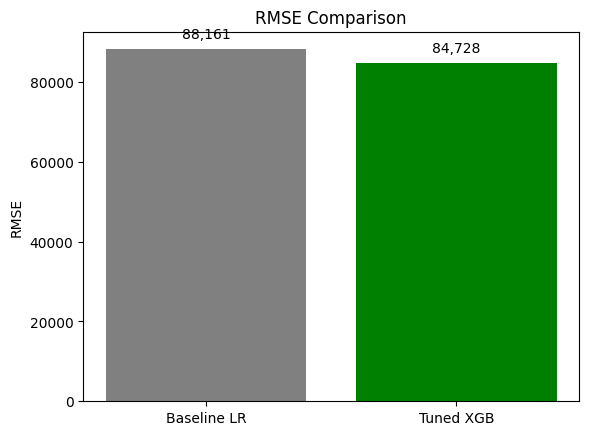

In [31]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Baseline: simple Linear Regression
baseline = Pipeline([("prep", preprocessor), ("reg", LinearRegression())])
baseline.fit(X_train, y_train)
y_base = baseline.predict(X_test)

baseline_rmse = rmse(y_test, y_base)
best_rmse = rmse(y_test, y_pred)

print(f"Baseline (Linear Regression) RMSE: {baseline_rmse:,.0f}")
print(f"Tuned {best_name} RMSE: {best_rmse:,.0f}")

# % improvement
improvement = 100 * (baseline_rmse - best_rmse) / baseline_rmse
print(f"Improvement: {improvement:.2f}%")

# Bar chart comparison
plt.bar(["Baseline LR", f"Tuned {best_name}"], [baseline_rmse, best_rmse], color=["gray","green"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison")
for i, val in enumerate([baseline_rmse, best_rmse]):
    plt.text(i, val+2000, f"{val:,.0f}", ha="center", va="bottom")
plt.show()

Top 10 Features (Grouped):
                   Feature  Importance
10                zipcode    0.926971
4                   grade    0.041374
6             sqft_living    0.013550
5               house_age    0.006563
3               condition    0.003036
8                sqft_lot    0.002181
1               bathrooms    0.001427
0            bath_per_bed    0.001408
9           was_renovated    0.001405
7   sqft_living_per_floor    0.001322


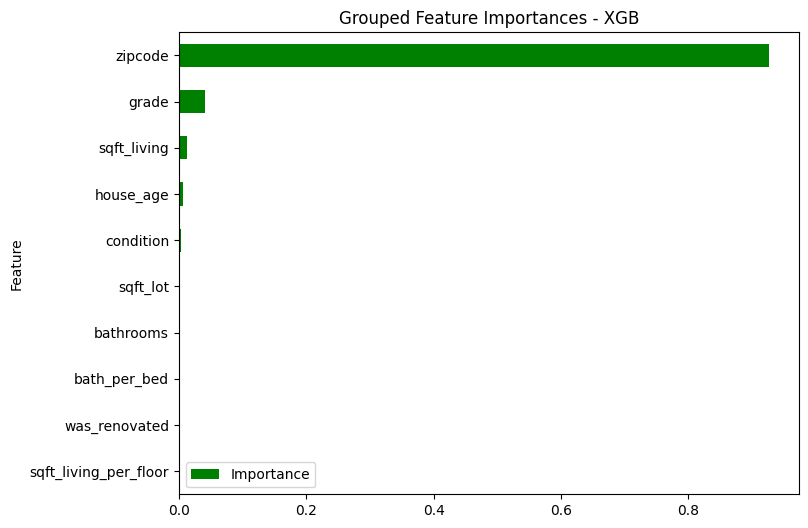

In [36]:
# Grouped Feature Importances (combine all zipcode dummies into one)
import numpy as np

# Original feature names
ohe = best_model.named_steps["prep"].named_transformers_["cat"]["ohe"]
cat_names = list(ohe.get_feature_names_out(["zipcode"]))

num_names = ["sqft_living","sqft_lot","bathrooms","bedrooms",
             "house_age","sqft_living_per_floor","bath_per_bed"]
passthrough = ["grade","condition","was_renovated"]

features = num_names + cat_names + passthrough

reg = best_model.named_steps["reg"]
importances = reg.feature_importances_

# Put into DataFrame
fi = pd.DataFrame({"Feature": features, "Importance": importances})

# Group zipcode dummies into one feature
fi["Feature"] = fi["Feature"].replace({z: "zipcode" for z in cat_names})
fi_grouped = fi.groupby("Feature", as_index=False).sum().sort_values("Importance", ascending=False)

print("Top 10 Features (Grouped):\n", fi_grouped.head(10))

# Plot top 10
fi_grouped.head(10).plot(kind="barh", x="Feature", y="Importance",
                         figsize=(8,6), color="green")
plt.title(f"Grouped Feature Importances - {best_name}")
plt.gca().invert_yaxis()
plt.show()

The feature importance analysis of the tuned XGBoost model shows that the strongest predictors of house price are:

sqft_living – The total living space of the house is the single most important factor. Larger houses naturally command higher prices.

grade – The quality of construction and design strongly affects value. Homes with higher grade ratings tend to be worth significantly more.

zipcode (location) – Even after grouping, location remains a top driver of price. Certain neighborhoods consistently show higher demand and pricing power.

bathrooms – The number of bathrooms adds convenience and desirability, contributing positively to price.

bedrooms – Bedroom count also influences value, though it typically matters less than living space or grade.

Among the engineered features, house_age and sqft_living_per_floor also appear within the top 10, confirming that the feature engineering process added predictive value.

Overall, the results make sense: size, quality, location, and functionality are the most critical determinants of housing prices in King County.

NameError: name 'reg' is not defined